__ComPy - Visualisation des données calculées (new vs old sources)__

## Importation des modules

In [2]:
import os # fonction systèmes
import glob # gestion répertoires
import pandas as pd # fonctions dataframe
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pyarrow as pa
from pyarrow import fs
import pyarrow.parquet as pq # pour gérer les fichiers parquet de notre datalake
import cx_Oracle
from sqlalchemy import create_engine

# Suppresion des warnings avec openpyxl
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

# ajout option pour multi affichage pour test
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython.display import display

## Variables

Ici on renseigne le code du pays dont on souhaite visualiser les données.

Les autres variables servent à se connecter au datalake pour importer les données obtenues avec les nouvelles (dossier _valid_) et les anciennes sources (dossier _old_)

In [41]:
pays = 'fra'

# connexion au datalake
hdfs = fs.HadoopFileSystem('dataprocess.enerdata.net',user='data', port=9000)

datapath = '/test/odyssee/'
olddata = datapath + 'old/'
newdata = datapath + 'valid/'

## Création des dataframes de données

In [65]:
# Chemins d'accès au fichier .parquet du pays
src_file_old = olddata  + pays + '.parquet'
src_file_new = newdata  + pays + '.parquet'

#Importation et suppression de l'attribut source (inutile ici)
old = pq.read_table(src_file_old, filesystem=hdfs).to_pandas()
new = pq.read_table(src_file_new, filesystem=hdfs).to_pandas()
old = old[['serie', 'zone', 'year', 'unite', 'value']]
new = new[['serie', 'zone', 'year', 'unite', 'value']]
#Conversion des colonnes années en entiers 
#(parfois la jointure peut ne pas se faire parce que l'une des séries a sa variable année en décimal)
new.year = new.year.astype(int)
old.year = old.year.astype(int)

#Fusion des deux df en distingant value et unite old/new
df = old.merge(new, 'outer', on=['serie', 'zone', 'year'], suffixes = ['_old', '_new'])
#On trie d'abord par ordre alphabétique des séries puis par année pour la représentation graphique
df = df.sort_values(['serie', 'year'])

#On importe la liste des séries clés et de leur domaine contenue dans un fichier csv
series_cles = pd.read_csv('config/series-cles.csv', sep=';')
#Par collage on obtient un df contenant uniquement les séries clés avec une colonne 'domaine'
df_cles = df.merge(series_cles, 'inner')

## Fonctions de visualisation des données

__Notes__
* d'autres fonctions peuvent être créées selon le même schéma, par exemple pour sélectionner les séries commençant par telle chaîne de caractères ;
* une autre amélioration souhaitable serait d'afficher les extraits du dataframe à côté des graphiques afin de faciliter le scrolling.

In [77]:
def viz_domaine(domaine):
    df = df_cles[df_cles.domaine==domaine]
    print(list(df.serie.unique()))
    plt.figure()
    for serie in df.serie.unique():
        df[df.serie==serie].plot(x='year', y=['value_old', 'value_new'], title=serie)
        plt.show()
        display(df[df.serie==serie])
        print("\n\n")
        
def viz_series(Lseries):
    plt.figure()
    for serie in Lseries:
        df[df.serie==serie].plot(x='year', y=['value_old', 'value_new'], title=serie)
        plt.show()
        display(df[df.serie==serie])
        print("\n\n")

## Visualisation des séries clés par domaine

La fonction `viz_domaine` permet d'afficher les données et les courbes de l'ensemble des séries clés rattachées au domaine passé en paramètre.

Domaines répertoriés : 'macro', 'industrie', 'industrieB', 'transport', 'residentiel', 'services', 'co2'

['cprxx', 'ietoccfcced', 'ietoctfc', 'ietoctfcajpp', 'ietoctfccc', 'ietoctfcce', 'ietoctfcppcc', 'ietoctpc', 'ietoctpcppcc', 'men', 'odexind', 'odexres', 'odexter', 'odextot', 'odextotobs', 'odextra', 'pibxx', 'pibxxppp', 'pop', 'toccf', 'toccfcc', 'toccfind', 'toccftra', 'toccp', 'vadagrxx', 'vadindxx', 'vadterxx']


<Figure size 432x288 with 0 Axes>

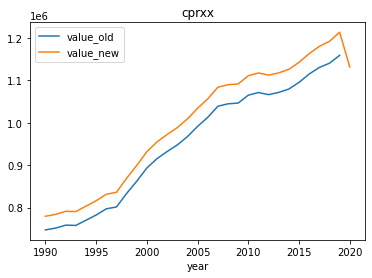

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
1350,cprxx,fra,1990,MEUR2010,7.473914e+05,MEUR2015,779577.1,macro
1351,cprxx,fra,1991,MEUR2010,7.516170e+05,MEUR2015,783984.6,macro
1352,cprxx,fra,1992,MEUR2010,7.586177e+05,MEUR2015,791286.8,macro
1353,cprxx,fra,1993,MEUR2010,7.580035e+05,MEUR2015,790646.1,macro
1354,cprxx,fra,1994,MEUR2010,7.702564e+05,MEUR2015,803426.7,macro
1355,cprxx,fra,1995,MEUR2010,7.824459e+05,MEUR2015,816141.1,macro
1356,cprxx,fra,1996,MEUR2010,7.970808e+05,MEUR2015,831406.2,macro
1357,cprxx,fra,1997,MEUR2010,8.014506e+05,MEUR2015,835964.2,macro
1358,cprxx,fra,1998,MEUR2010,8.331792e+05,MEUR2015,869059.1,macro
1359,cprxx,fra,1999,MEUR2010,8.620452e+05,MEUR2015,899168.2,macro


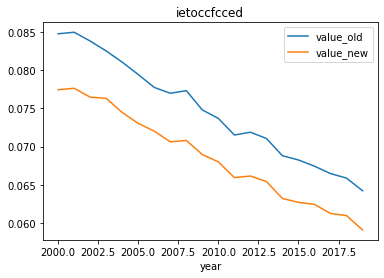

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
3972,ietoccfcced,fra,2000,koe/EUR2010,0.084779,koe/EUR2015,0.077447,macro
3973,ietoccfcced,fra,2001,koe/EUR2010,0.084980,koe/EUR2015,0.077637,macro
3974,ietoccfcced,fra,2002,koe/EUR2010,0.083824,koe/EUR2015,0.076476,macro
3975,ietoccfcced,fra,2003,koe/EUR2010,0.082525,koe/EUR2015,0.076317,macro
3976,ietoccfcced,fra,2004,koe/EUR2010,0.081059,koe/EUR2015,0.074469,macro
3977,ietoccfcced,fra,2005,koe/EUR2010,0.079439,koe/EUR2015,0.073038,macro
3978,ietoccfcced,fra,2006,koe/EUR2010,0.077753,koe/EUR2015,0.072020,macro
3979,ietoccfcced,fra,2007,koe/EUR2010,0.076984,koe/EUR2015,0.070623,macro
3980,ietoccfcced,fra,2008,koe/EUR2010,0.077327,koe/EUR2015,0.070804,macro
3981,ietoccfcced,fra,2009,koe/EUR2010,0.074802,koe/EUR2015,0.068960,macro


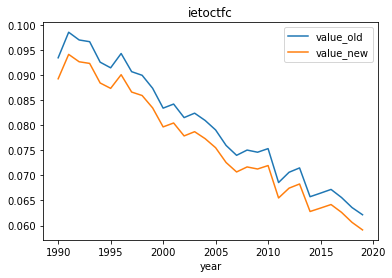

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
5098,ietoctfc,fra,1990,koe/EUR2010,0.093411,koe/EUR2015,0.089228,macro
5099,ietoctfc,fra,1991,koe/EUR2010,0.098498,koe/EUR2015,0.094088,macro
5100,ietoctfc,fra,1992,koe/EUR2010,0.096960,koe/EUR2015,0.092618,macro
5101,ietoctfc,fra,1993,koe/EUR2010,0.096618,koe/EUR2015,0.092292,macro
5102,ietoctfc,fra,1994,koe/EUR2010,0.092539,koe/EUR2015,0.088395,macro
5103,ietoctfc,fra,1995,koe/EUR2010,0.091414,koe/EUR2015,0.087321,macro
5104,ietoctfc,fra,1996,koe/EUR2010,0.094264,koe/EUR2015,0.090044,macro
5105,ietoctfc,fra,1997,koe/EUR2010,0.090648,koe/EUR2015,0.086590,macro
5106,ietoctfc,fra,1998,koe/EUR2010,0.089926,koe/EUR2015,0.085900,macro
5107,ietoctfc,fra,1999,koe/EUR2010,0.087343,koe/EUR2015,0.083433,macro


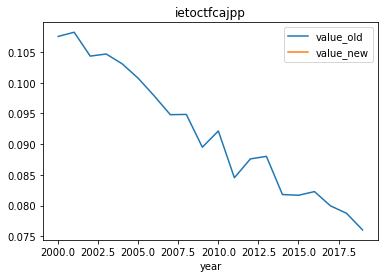

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
5128,ietoctfcajpp,fra,2000,koe/EUR2010p,0.107526,NaN,NaN,macro
5129,ietoctfcajpp,fra,2001,koe/EUR2010p,0.108205,NaN,NaN,macro
5130,ietoctfcajpp,fra,2002,koe/EUR2010p,0.104323,NaN,NaN,macro
5131,ietoctfcajpp,fra,2003,koe/EUR2010p,0.104661,NaN,NaN,macro
5132,ietoctfcajpp,fra,2004,koe/EUR2010p,0.103058,NaN,NaN,macro
5133,ietoctfcajpp,fra,2005,koe/EUR2010p,0.100704,NaN,NaN,macro
5134,ietoctfcajpp,fra,2006,koe/EUR2010p,0.097833,NaN,NaN,macro
5135,ietoctfcajpp,fra,2007,koe/EUR2010p,0.094791,NaN,NaN,macro
5136,ietoctfcajpp,fra,2008,koe/EUR2010p,0.094831,NaN,NaN,macro
5137,ietoctfcajpp,fra,2009,koe/EUR2010p,0.089499,NaN,NaN,macro


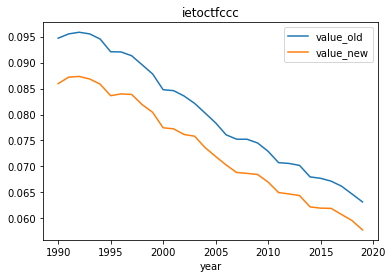

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
5148,ietoctfccc,fra,1990,koe/EUR2010,0.094699,koe/EUR2015,0.085949,macro
5149,ietoctfccc,fra,1991,koe/EUR2010,0.095530,koe/EUR2015,0.087197,macro
5150,ietoctfccc,fra,1992,koe/EUR2010,0.095849,koe/EUR2015,0.087337,macro
5151,ietoctfccc,fra,1993,koe/EUR2010,0.095532,koe/EUR2015,0.086847,macro
5152,ietoctfccc,fra,1994,koe/EUR2010,0.094539,koe/EUR2015,0.085850,macro
5153,ietoctfccc,fra,1995,koe/EUR2010,0.092094,koe/EUR2015,0.083628,macro
5154,ietoctfccc,fra,1996,koe/EUR2010,0.092052,koe/EUR2015,0.083969,macro
5155,ietoctfccc,fra,1997,koe/EUR2010,0.091321,koe/EUR2015,0.083867,macro
5156,ietoctfccc,fra,1998,koe/EUR2010,0.089581,koe/EUR2015,0.081912,macro
5157,ietoctfccc,fra,1999,koe/EUR2010,0.087815,koe/EUR2015,0.080424,macro


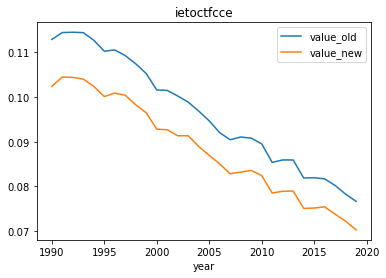

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
5178,ietoctfcce,fra,1990,koe/EUR2010,0.112916,koe/EUR2015,0.102416,macro
5179,ietoctfcce,fra,1991,koe/EUR2010,0.114467,koe/EUR2015,0.104494,macro
5180,ietoctfcce,fra,1992,koe/EUR2010,0.114534,koe/EUR2015,0.104416,macro
5181,ietoctfcce,fra,1993,koe/EUR2010,0.114451,koe/EUR2015,0.104040,macro
5182,ietoctfcce,fra,1994,koe/EUR2010,0.112735,koe/EUR2015,0.102408,macro
5183,ietoctfcce,fra,1995,koe/EUR2010,0.110294,koe/EUR2015,0.100117,macro
5184,ietoctfcce,fra,1996,koe/EUR2010,0.110568,koe/EUR2015,0.100902,macro
5185,ietoctfcce,fra,1997,koe/EUR2010,0.109299,koe/EUR2015,0.100407,macro
5186,ietoctfcce,fra,1998,koe/EUR2010,0.107460,koe/EUR2015,0.098275,macro
5187,ietoctfcce,fra,1999,koe/EUR2010,0.105268,koe/EUR2015,0.096477,macro


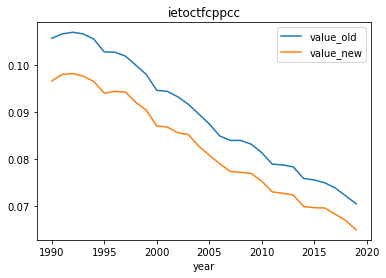

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
5208,ietoctfcppcc,fra,1990,koe/EUR2010p,0.105763,koe/EUR2015p,0.096691,macro
5209,ietoctfcppcc,fra,1991,koe/EUR2010p,0.106692,koe/EUR2015p,0.098094,macro
5210,ietoctfcppcc,fra,1992,koe/EUR2010p,0.107048,koe/EUR2015p,0.098252,macro
5211,ietoctfcppcc,fra,1993,koe/EUR2010p,0.106694,koe/EUR2015p,0.097700,macro
5212,ietoctfcppcc,fra,1994,koe/EUR2010p,0.105585,koe/EUR2015p,0.096579,macro
5213,ietoctfcppcc,fra,1995,koe/EUR2010p,0.102855,koe/EUR2015p,0.094079,macro
5214,ietoctfcppcc,fra,1996,koe/EUR2010p,0.102807,koe/EUR2015p,0.094463,macro
5215,ietoctfcppcc,fra,1997,koe/EUR2010p,0.101991,koe/EUR2015p,0.094348,macro
5216,ietoctfcppcc,fra,1998,koe/EUR2010p,0.100048,koe/EUR2015p,0.092149,macro
5217,ietoctfcppcc,fra,1999,koe/EUR2010p,0.098076,koe/EUR2015p,0.090475,macro


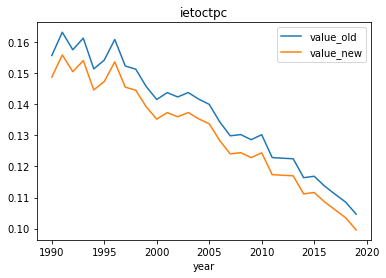

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
5238,ietoctpc,fra,1990,koe/EUR2010,0.155743,koe/EUR2015,0.148769,macro
5239,ietoctpc,fra,1991,koe/EUR2010,0.163238,koe/EUR2015,0.155929,macro
5240,ietoctpc,fra,1992,koe/EUR2010,0.157597,koe/EUR2015,0.150540,macro
5241,ietoctpc,fra,1993,koe/EUR2010,0.161335,koe/EUR2015,0.154112,macro
5242,ietoctpc,fra,1994,koe/EUR2010,0.151430,koe/EUR2015,0.144650,macro
5243,ietoctpc,fra,1995,koe/EUR2010,0.154270,koe/EUR2015,0.147362,macro
5244,ietoctpc,fra,1996,koe/EUR2010,0.160910,koe/EUR2015,0.153706,macro
5245,ietoctpc,fra,1997,koe/EUR2010,0.152367,koe/EUR2015,0.145545,macro
5246,ietoctpc,fra,1998,koe/EUR2010,0.151343,koe/EUR2015,0.144567,macro
5247,ietoctpc,fra,1999,koe/EUR2010,0.145728,koe/EUR2015,0.139203,macro


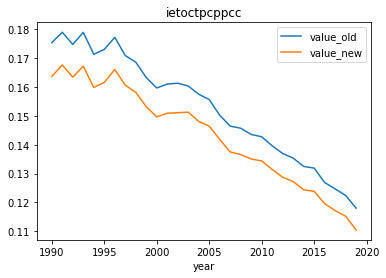

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
5268,ietoctpcppcc,fra,1990,koe/EUR2010p,0.175378,koe/EUR2015p,0.163673,macro
5269,ietoctpcppcc,fra,1991,koe/EUR2010p,0.178996,koe/EUR2015p,0.167663,macro
5270,ietoctpcppcc,fra,1992,koe/EUR2010p,0.174770,koe/EUR2015p,0.163413,macro
5271,ietoctpcppcc,fra,1993,koe/EUR2010p,0.178973,koe/EUR2015p,0.167245,macro
5272,ietoctpcppcc,fra,1994,koe/EUR2010p,0.171357,koe/EUR2015p,0.159864,macro
5273,ietoctpcppcc,fra,1995,koe/EUR2010p,0.173054,koe/EUR2015p,0.161624,macro
5274,ietoctpcppcc,fra,1996,koe/EUR2010p,0.177240,koe/EUR2015p,0.166081,macro
5275,ietoctpcppcc,fra,1997,koe/EUR2010p,0.170921,koe/EUR2015p,0.160671,macro
5276,ietoctpcppcc,fra,1998,koe/EUR2010p,0.168640,koe/EUR2015p,0.158147,macro
5277,ietoctpcppcc,fra,1999,koe/EUR2010p,0.163282,koe/EUR2015p,0.153214,macro


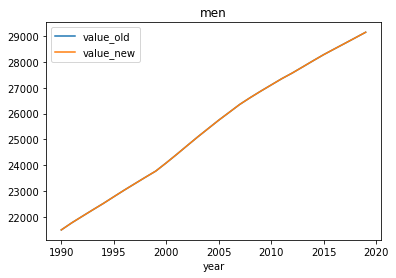

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
7184,men,fra,1990,k,21496.0,k,21496.0,macro
7185,men,fra,1991,k,21771.0,k,21771.0,macro
7186,men,fra,1992,k,22023.0,k,22023.0,macro
7187,men,fra,1993,k,22273.0,k,22273.0,macro
7188,men,fra,1994,k,22519.0,k,22519.0,macro
7189,men,fra,1995,k,22779.0,k,22779.0,macro
7190,men,fra,1996,k,23036.0,k,23036.0,macro
7191,men,fra,1997,k,23284.0,k,23284.0,macro
7192,men,fra,1998,k,23531.0,k,23531.0,macro
7193,men,fra,1999,k,23773.0,k,23773.0,macro


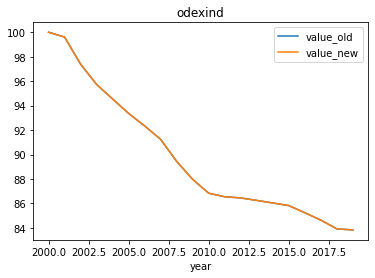

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
7214,odexind,fra,2000,2000=100,100.000000,2000=100,100.000000,macro
7217,odexind,fra,2001,2000=100,99.606599,2000=100,99.606599,macro
7220,odexind,fra,2002,2000=100,97.393297,2000=100,97.393297,macro
7223,odexind,fra,2003,2000=100,95.730065,2000=100,95.730065,macro
7226,odexind,fra,2004,2000=100,94.543777,2000=100,94.543777,macro
7229,odexind,fra,2005,2000=100,93.362143,2000=100,93.362143,macro
7232,odexind,fra,2006,2000=100,92.338413,2000=100,92.338413,macro
7235,odexind,fra,2007,2000=100,91.237810,2000=100,91.237810,macro
7238,odexind,fra,2008,2000=100,89.436306,2000=100,89.436306,macro
7241,odexind,fra,2009,2000=100,87.966237,2000=100,87.966237,macro


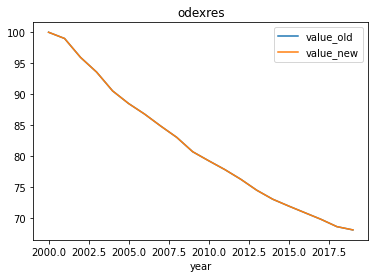

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
7394,odexres,fra,2000,2000=100,100.000000,2000=100,100.000000,macro
7396,odexres,fra,2001,2000=100,98.993577,2000=100,98.993577,macro
7398,odexres,fra,2002,2000=100,95.933151,2000=100,95.933151,macro
7400,odexres,fra,2003,2000=100,93.568506,2000=100,93.568506,macro
7402,odexres,fra,2004,2000=100,90.526727,2000=100,90.526727,macro
7404,odexres,fra,2005,2000=100,88.488589,2000=100,88.488589,macro
7406,odexres,fra,2006,2000=100,86.781634,2000=100,86.781634,macro
7408,odexres,fra,2007,2000=100,84.861644,2000=100,84.861644,macro
7410,odexres,fra,2008,2000=100,83.037697,2000=100,83.037697,macro
7412,odexres,fra,2009,2000=100,80.709469,2000=100,80.709469,macro


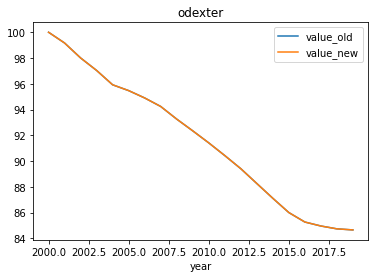

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
7494,odexter,fra,2000,2000=100,100.000000,2000=100,100.000000,macro
7496,odexter,fra,2001,2000=100,99.165183,2000=100,99.165183,macro
7498,odexter,fra,2002,2000=100,98.004406,2000=100,98.004406,macro
7500,odexter,fra,2003,2000=100,97.033297,2000=100,97.033297,macro
7502,odexter,fra,2004,2000=100,95.919167,2000=100,95.919167,macro
7504,odexter,fra,2005,2000=100,95.467113,2000=100,95.467113,macro
7506,odexter,fra,2006,2000=100,94.896927,2000=100,94.896927,macro
7508,odexter,fra,2007,2000=100,94.236519,2000=100,94.236519,macro
7510,odexter,fra,2008,2000=100,93.254972,2000=100,93.254972,macro
7512,odexter,fra,2009,2000=100,92.343935,2000=100,92.343935,macro


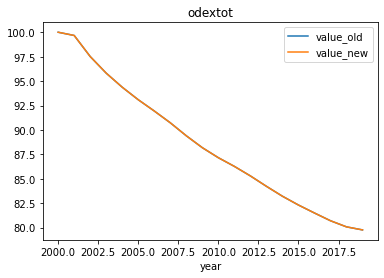

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
7554,odextot,fra,2000,2000=100,100.000000,2000=100,100.000000,macro
7555,odextot,fra,2001,2000=100,99.670097,2000=100,99.670097,macro
7556,odextot,fra,2002,2000=100,97.513727,2000=100,97.513727,macro
7557,odextot,fra,2003,2000=100,95.810233,2000=100,95.810233,macro
7558,odextot,fra,2004,2000=100,94.371807,2000=100,94.371807,macro
7559,odextot,fra,2005,2000=100,93.090769,2000=100,93.090769,macro
7560,odextot,fra,2006,2000=100,91.937002,2000=100,91.937002,macro
7561,odextot,fra,2007,2000=100,90.730652,2000=100,90.730652,macro
7562,odextot,fra,2008,2000=100,89.399795,2000=100,89.399795,macro
7563,odextot,fra,2009,2000=100,88.182696,2000=100,88.182696,macro


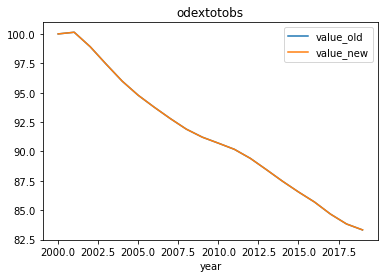

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
7574,odextotobs,fra,2000,2000=100,100.000000,2000=100,100.000000,macro
7575,odextotobs,fra,2001,2000=100,100.142235,2000=100,100.142235,macro
7576,odextotobs,fra,2002,2000=100,98.910069,2000=100,98.910069,macro
7577,odextotobs,fra,2003,2000=100,97.420110,2000=100,97.420110,macro
7578,odextotobs,fra,2004,2000=100,95.977639,2000=100,95.977639,macro
7579,odextotobs,fra,2005,2000=100,94.775892,2000=100,94.775892,macro
7580,odextotobs,fra,2006,2000=100,93.761982,2000=100,93.761982,macro
7581,odextotobs,fra,2007,2000=100,92.797857,2000=100,92.797857,macro
7582,odextotobs,fra,2008,2000=100,91.898366,2000=100,91.898366,macro
7583,odextotobs,fra,2009,2000=100,91.215024,2000=100,91.215024,macro


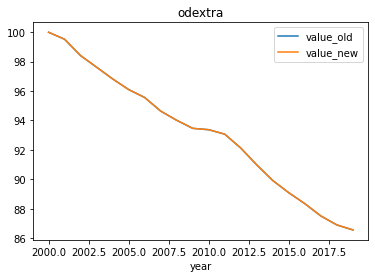

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
7594,odextra,fra,2000,2000=100,100.000000,2000=100,100.000000,macro
7596,odextra,fra,2001,2000=100,99.524092,2000=100,99.524092,macro
7598,odextra,fra,2002,2000=100,98.410794,2000=100,98.410794,macro
7600,odextra,fra,2003,2000=100,97.622575,2000=100,97.622575,macro
7602,odextra,fra,2004,2000=100,96.828105,2000=100,96.828105,macro
7604,odextra,fra,2005,2000=100,96.104562,2000=100,96.104562,macro
7606,odextra,fra,2006,2000=100,95.564352,2000=100,95.564352,macro
7608,odextra,fra,2007,2000=100,94.639582,2000=100,94.639582,macro
7610,odextra,fra,2008,2000=100,94.013105,2000=100,94.013105,macro
7612,odextra,fra,2009,2000=100,93.466127,2000=100,93.466127,macro


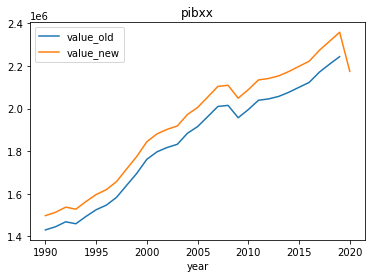

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
8149,pibxx,fra,1990,MEUR2010,1.430101e+06,MEUR2015,1497135.3,macro
8150,pibxx,fra,1991,MEUR2010,1.445091e+06,MEUR2015,1512827.9,macro
8151,pibxx,fra,1992,MEUR2010,1.468203e+06,MEUR2015,1537023.3,macro
8152,pibxx,fra,1993,MEUR2010,1.458973e+06,MEUR2015,1527360.5,macro
8153,pibxx,fra,1994,MEUR2010,1.493381e+06,MEUR2015,1563380.9,macro
8154,pibxx,fra,1995,MEUR2010,1.524842e+06,MEUR2015,1596316.6,macro
8155,pibxx,fra,1996,MEUR2010,1.546388e+06,MEUR2015,1618872.4,macro
8156,pibxx,fra,1997,MEUR2010,1.582516e+06,MEUR2015,1656694.1,macro
8157,pibxx,fra,1998,MEUR2010,1.639307e+06,MEUR2015,1716147.2,macro
8158,pibxx,fra,1999,MEUR2010,1.695394e+06,MEUR2015,1774863.0,macro


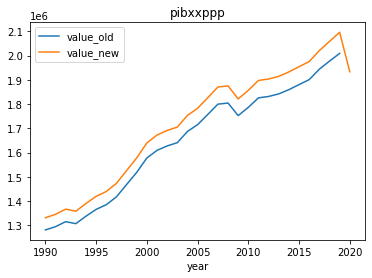

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
8180,pibxxppp,fra,1990,MEUR2010p,1.280489e+06,MEUR2015p,1.330822e+06,macro
8181,pibxxppp,fra,1991,MEUR2010p,1.293911e+06,MEUR2015p,1.344772e+06,macro
8182,pibxxppp,fra,1992,MEUR2010p,1.314605e+06,MEUR2015p,1.366279e+06,macro
8183,pibxxppp,fra,1993,MEUR2010p,1.306340e+06,MEUR2015p,1.357690e+06,macro
8184,pibxxppp,fra,1994,MEUR2010p,1.337148e+06,MEUR2015p,1.389709e+06,macro
8185,pibxxppp,fra,1995,MEUR2010p,1.365318e+06,MEUR2015p,1.418986e+06,macro
8186,pibxxppp,fra,1996,MEUR2010p,1.384610e+06,MEUR2015p,1.439036e+06,macro
8187,pibxxppp,fra,1997,MEUR2010p,1.416958e+06,MEUR2015p,1.472656e+06,macro
8188,pibxxppp,fra,1998,MEUR2010p,1.467808e+06,MEUR2015p,1.525505e+06,macro
8189,pibxxppp,fra,1999,MEUR2010p,1.518027e+06,MEUR2015p,1.577698e+06,macro


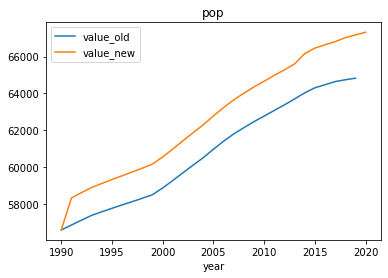

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
8211,pop,fra,1990,k,56577.000,k,56577.000,macro
8212,pop,fra,1991,k,56840.661,k,58313.439,macro
8213,pop,fra,1992,k,57110.533,k,58604.851,macro
8214,pop,fra,1993,k,57369.161,k,58885.929,macro
8215,pop,fra,1994,k,57565.008,k,59104.320,macro
8216,pop,fra,1995,k,57752.535,k,59315.139,macro
8217,pop,fra,1996,k,57935.959,k,59522.297,macro
8218,pop,fra,1997,k,58116.018,k,59726.386,macro
8219,pop,fra,1998,k,58298.962,k,59934.884,macro
8220,pop,fra,1999,k,58496.613,k,60158.533,macro


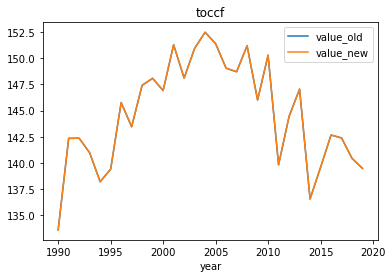

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
8728,toccf,fra,1990,Mtoe,133.586539,Mtoe,133.586539,macro
8729,toccf,fra,1991,Mtoe,142.339251,Mtoe,142.339251,macro
8730,toccf,fra,1992,Mtoe,142.356369,Mtoe,142.356369,macro
8731,toccf,fra,1993,Mtoe,140.962913,Mtoe,140.962913,macro
8732,toccf,fra,1994,Mtoe,138.195616,Mtoe,138.195616,macro
8733,toccf,fra,1995,Mtoe,139.391483,Mtoe,139.391483,macro
8734,toccf,fra,1996,Mtoe,145.768998,Mtoe,145.768998,macro
8735,toccf,fra,1997,Mtoe,143.452598,Mtoe,143.452598,macro
8736,toccf,fra,1998,Mtoe,147.417025,Mtoe,147.417025,macro
8737,toccf,fra,1999,Mtoe,148.081452,Mtoe,148.081452,macro


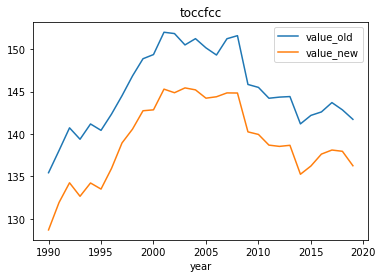

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
8878,toccfcc,fra,1990,Mtoe,135.428702,Mtoe,128.677962,macro
8879,toccfcc,fra,1991,Mtoe,138.049670,Mtoe,131.913433,macro
8880,toccfcc,fra,1992,Mtoe,140.725397,Mtoe,134.239600,macro
8881,toccfcc,fra,1993,Mtoe,139.378522,Mtoe,132.646041,macro
8882,toccfcc,fra,1994,Mtoe,141.182202,Mtoe,134.217004,macro
8883,toccfcc,fra,1995,Mtoe,140.429231,Mtoe,133.497365,macro
8884,toccfcc,fra,1996,Mtoe,142.347846,Mtoe,135.935900,macro
8885,toccfcc,fra,1997,Mtoe,144.517449,Mtoe,138.942278,macro
8886,toccfcc,fra,1998,Mtoe,146.850927,Mtoe,140.573189,macro
8887,toccfcc,fra,1999,Mtoe,148.881787,Mtoe,142.741643,macro


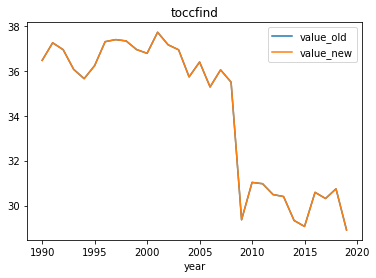

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
9328,toccfind,fra,1990,Mtoe,36.463352,Mtoe,36.463352,macro
9330,toccfind,fra,1991,Mtoe,37.246731,Mtoe,37.246731,macro
9332,toccfind,fra,1992,Mtoe,36.940778,Mtoe,36.940778,macro
9334,toccfind,fra,1993,Mtoe,36.065451,Mtoe,36.065451,macro
9336,toccfind,fra,1994,Mtoe,35.648452,Mtoe,35.648452,macro
9338,toccfind,fra,1995,Mtoe,36.230921,Mtoe,36.230921,macro
9340,toccfind,fra,1996,Mtoe,37.295833,Mtoe,37.295833,macro
9342,toccfind,fra,1997,Mtoe,37.388614,Mtoe,37.388614,macro
9344,toccfind,fra,1998,Mtoe,37.328948,Mtoe,37.328948,macro
9346,toccfind,fra,1999,Mtoe,36.944388,Mtoe,36.944388,macro


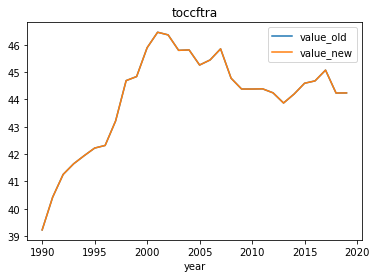

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
10078,toccftra,fra,1990,Mtoe,39.227396,Mtoe,39.227396,macro
10079,toccftra,fra,1991,Mtoe,40.425126,Mtoe,40.425126,macro
10080,toccftra,fra,1992,Mtoe,41.257275,Mtoe,41.257275,macro
10081,toccftra,fra,1993,Mtoe,41.646411,Mtoe,41.646411,macro
10082,toccftra,fra,1994,Mtoe,41.941684,Mtoe,41.941684,macro
10083,toccftra,fra,1995,Mtoe,42.220866,Mtoe,42.220866,macro
10084,toccftra,fra,1996,Mtoe,42.317014,Mtoe,42.317014,macro
10085,toccftra,fra,1997,Mtoe,43.214987,Mtoe,43.214987,macro
10086,toccftra,fra,1998,Mtoe,44.688078,Mtoe,44.688078,macro
10087,toccftra,fra,1999,Mtoe,44.836668,Mtoe,44.836668,macro


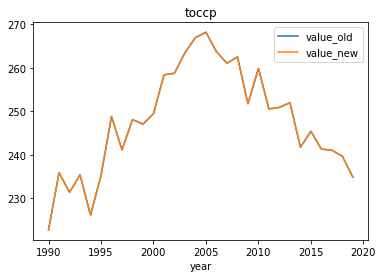

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
10248,toccp,fra,1990,Mtoe,222.727952,Mtoe,222.727952,macro
10249,toccp,fra,1991,Mtoe,235.893996,Mtoe,235.893996,macro
10250,toccp,fra,1992,Mtoe,231.383985,Mtoe,231.383985,macro
10251,toccp,fra,1993,Mtoe,235.383940,Mtoe,235.383940,macro
10252,toccp,fra,1994,Mtoe,226.142489,Mtoe,226.142489,macro
10253,toccp,fra,1995,Mtoe,235.236589,Mtoe,235.236589,macro
10254,toccp,fra,1996,Mtoe,248.829627,Mtoe,248.829627,macro
10255,toccp,fra,1997,Mtoe,241.123155,Mtoe,241.123155,macro
10256,toccp,fra,1998,Mtoe,248.097686,Mtoe,248.097686,macro
10257,toccp,fra,1999,Mtoe,247.065565,Mtoe,247.065565,macro


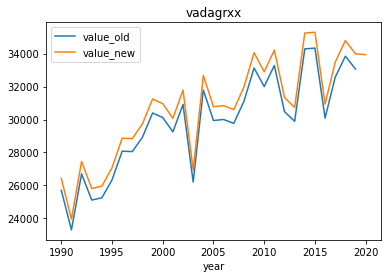

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
10278,vadagrxx,fra,1990,MEUR2010,25705.255051,MEUR2015,26425.0,macro
10279,vadagrxx,fra,1991,MEUR2010,23300.960005,MEUR2015,23953.4,macro
10280,vadagrxx,fra,1992,MEUR2010,26706.532230,MEUR2015,27454.3,macro
10281,vadagrxx,fra,1993,MEUR2010,25112.892504,MEUR2015,25816.0,macro
10282,vadagrxx,fra,1994,MEUR2010,25251.247078,MEUR2015,25958.3,macro
10283,vadagrxx,fra,1995,MEUR2010,26336.561850,MEUR2015,27074.0,macro
10284,vadagrxx,fra,1996,MEUR2010,28077.779788,MEUR2015,28864.0,macro
10285,vadagrxx,fra,1997,MEUR2010,28055.233117,MEUR2015,28840.8,macro
10286,vadagrxx,fra,1998,MEUR2010,28929.429056,MEUR2015,29739.4,macro
10287,vadagrxx,fra,1999,MEUR2010,30398.037241,MEUR2015,31249.2,macro


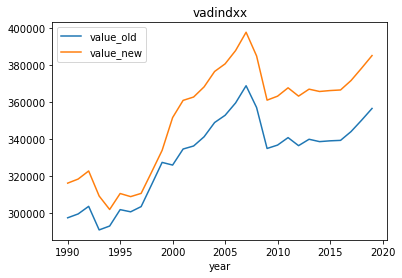

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
10769,vadindxx,fra,1990,MEUR2010,297671.625037,MEUR2014,316399.0,macro
10771,vadindxx,fra,1991,MEUR2010,299755.521160,MEUR2014,318614.0,macro
10773,vadindxx,fra,1992,MEUR2010,303855.575022,MEUR2014,322972.0,macro
10775,vadindxx,fra,1993,MEUR2010,291116.995561,MEUR2014,309432.0,macro
10777,vadindxx,fra,1994,MEUR2010,293219.707902,MEUR2015,302159.1,macro
10779,vadindxx,fra,1995,MEUR2010,302081.205682,MEUR2015,310793.6,macro
10781,vadindxx,fra,1996,MEUR2010,300904.251258,MEUR2015,309116.1,macro
10783,vadindxx,fra,1997,MEUR2010,303716.335010,MEUR2015,310860.5,macro
10785,vadindxx,fra,1998,MEUR2010,315603.480616,MEUR2015,322394.3,macro
10787,vadindxx,fra,1999,MEUR2010,327614.813258,MEUR2015,334127.9,macro


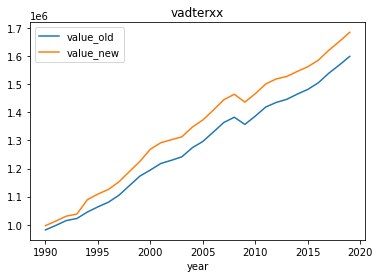

,serie,zone,year,unite_old,value_old,unite_new,value_new,domaine
11010,vadterxx,fra,1990,MEUR2010,9.817006e+05,MEUR2014,996794.0,macro
11012,vadterxx,fra,1991,MEUR2010,9.979468e+05,MEUR2014,1013290.0,macro
11014,vadterxx,fra,1992,MEUR2010,1.015109e+06,MEUR2014,1030716.0,macro
11016,vadterxx,fra,1993,MEUR2010,1.022371e+06,MEUR2014,1038090.0,macro
11018,vadterxx,fra,1994,MEUR2010,1.045324e+06,MEUR2015,1089397.2,macro
11020,vadterxx,fra,1995,MEUR2010,1.063692e+06,MEUR2015,1109103.1,macro
11022,vadterxx,fra,1996,MEUR2010,1.080264e+06,MEUR2015,1125775.4,macro
11024,vadterxx,fra,1997,MEUR2010,1.104828e+06,MEUR2015,1152528.1,macro
11026,vadterxx,fra,1998,MEUR2010,1.139075e+06,MEUR2015,1189268.5,macro
11028,vadterxx,fra,1999,MEUR2010,1.173075e+06,MEUR2015,1225344.0,macro


In [78]:
domaine = 'macro'

viz_domaine(domaine)

## Visualisation libre des données

Ici, on peut consulter les graphiques et données des séries de son choix : il suffit pour ça de les affecter à la variable _series\_voulues_ sous forme de liste et  fonction `viz_series` s'occupe de les afficher

<Figure size 432x288 with 0 Axes>

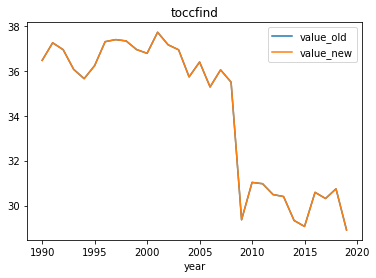

,serie,zone,year,unite_old,value_old,unite_new,value_new
14485,toccfind,fra,1990,Mtoe,36.463352,Mtoe,36.463352
14486,toccfind,fra,1991,Mtoe,37.246731,Mtoe,37.246731
14487,toccfind,fra,1992,Mtoe,36.940778,Mtoe,36.940778
14488,toccfind,fra,1993,Mtoe,36.065451,Mtoe,36.065451
14489,toccfind,fra,1994,Mtoe,35.648452,Mtoe,35.648452
14490,toccfind,fra,1995,Mtoe,36.230921,Mtoe,36.230921
14491,toccfind,fra,1996,Mtoe,37.295833,Mtoe,37.295833
14492,toccfind,fra,1997,Mtoe,37.388614,Mtoe,37.388614
14493,toccfind,fra,1998,Mtoe,37.328948,Mtoe,37.328948
14494,toccfind,fra,1999,Mtoe,36.944388,Mtoe,36.944388


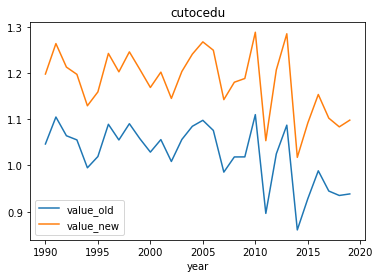

,serie,zone,year,unite_old,value_old,unite_new,value_new
55986,cutocedu,fra,1990,toe/emp,1.046404,toe/emp,1.197611
55987,cutocedu,fra,1991,toe/emp,1.104680,toe/emp,1.263441
55988,cutocedu,fra,1992,toe/emp,1.064251,toe/emp,1.212646
55989,cutocedu,fra,1993,toe/emp,1.055235,toe/emp,1.196908
55990,cutocedu,fra,1994,toe/emp,0.994928,toe/emp,1.129033
55991,cutocedu,fra,1995,toe/emp,1.019331,toe/emp,1.159019
55992,cutocedu,fra,1996,toe/emp,1.088968,toe/emp,1.242139
55993,cutocedu,fra,1997,toe/emp,1.055153,toe/emp,1.202373
55994,cutocedu,fra,1998,toe/emp,1.090247,toe/emp,1.245566
55995,cutocedu,fra,1999,toe/emp,1.057840,toe/emp,1.207531


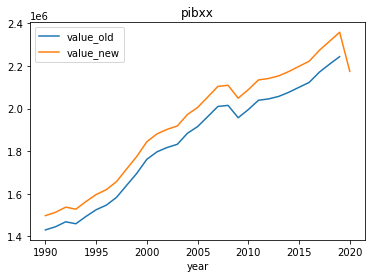

,serie,zone,year,unite_old,value_old,unite_new,value_new
10825,pibxx,fra,1990,MEUR2010,1.430101e+06,MEUR2015,1497135.3
10826,pibxx,fra,1991,MEUR2010,1.445091e+06,MEUR2015,1512827.9
10827,pibxx,fra,1992,MEUR2010,1.468203e+06,MEUR2015,1537023.3
10828,pibxx,fra,1993,MEUR2010,1.458973e+06,MEUR2015,1527360.5
10829,pibxx,fra,1994,MEUR2010,1.493381e+06,MEUR2015,1563380.9
10830,pibxx,fra,1995,MEUR2010,1.524842e+06,MEUR2015,1596316.6
10831,pibxx,fra,1996,MEUR2010,1.546388e+06,MEUR2015,1618872.4
10832,pibxx,fra,1997,MEUR2010,1.582516e+06,MEUR2015,1656694.1
10833,pibxx,fra,1998,MEUR2010,1.639307e+06,MEUR2015,1716147.2
10834,pibxx,fra,1999,MEUR2010,1.695394e+06,MEUR2015,1774863.0


In [64]:
series_voulues = ['toccfind', 'cutocedu', 'pibxx']

viz_series(series_voulues)